### NYC Taxi Trip Analysis (yr 2019 - 2021)

#### Read Data

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, dayofweek, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek

In [2]:
# spark = SparkSession.builder.appName('App')\
#         .config("spark.executor.cores",'16')\
#         .config("spark.executor.memory", '60g')\
#         .getOrCreate()
spark = SparkSession.builder.appName('App').getOrCreate()

In [3]:
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

In [4]:
# df2021 = df2021.withColumn("Datayear", lit(2021))
# df2020 = df2020.withColumn("Datayear", lit(2020))
# df2019 = df2019.withColumn("Datayear", lit(2019))

In [5]:
# union_df = df2021.union(df2020).union(df2019)

#### Sampling Data

In [6]:
sampled_2021 = df2021.sample(fraction=0.001, seed=12)
sampled_2020 = df2020.sample(fraction=0.001, seed=34)
sampled_2019 = df2019.sample(fraction=0.001, seed=56)

In [7]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [8]:
print(sampled_2021 .count(),len(sampled_2021 .columns))

31103 19


In [9]:
sampled_2021.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)



In [10]:
sampled_2021.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|       2|01/01/2021 01:45:...| 01/01/2021 02:00:...|              1|         4.62|         1|                 N|          50|          74|           2|       15.5|  0.5|    0.5|       0.0|       

In [11]:
union_df = sampled_2021.union(sampled_2020).union(sampled_2019)

#### Check Number of Partitions - Equally partitioned

In [12]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [13]:
#number of partitions
union_df.rdd.getNumPartitions()

103

In [14]:
#re-partition the data to evenly distributed across 32 partitions
union_df = union_df.repartition(32)
displaypartitions(union_df)

Partitions: 32


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         23| 4331|
|         22| 4335|
|         21| 4337|
|         20| 4339|
|         19| 4345|
|         18| 4352|
|         17| 4358|
|         16| 4362|
|         15| 4366|
|         14| 4369|
|         13| 4374|
|         12| 4378|
|         11| 4382|
|         10| 4386|
|          9| 4387|
|          8| 4390|
|          7| 4393|
|          6| 4394|
|          5| 4396|
|          3| 4401|
|          4| 4401|
|          2| 4403|
|          1| 4404|
|          0| 4409|
|         31| 4411|
|         30| 4413|
|         29| 4414|
|         28| 4418|
|         27| 4420|
|         26| 4424|
|         25| 4426|
|         24| 4429|
+-----------+-----+



#### Feature Engineering

In [15]:
# change to date type
union_df = union_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df = union_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [16]:
# calcualte average spent per mile and avergae spent per min
union_df = union_df.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
union_df = union_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

union_df = union_df.withColumn("PerMin", col("total_amount") / col("Dur"))

In [17]:
union_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+------------------+---+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|           PerMile|Dur|            PerMin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+-------------------

#### Visualize the pickup & dropoff locations

In [18]:
union_df.select('PULocationID','DOLocationID').show()

+------------+------------+
|PULocationID|DOLocationID|
+------------+------------+
|         265|         140|
|         236|         237|
|         143|         239|
|         239|         238|
|         170|         237|
|         140|          43|
|         244|         249|
|          43|         163|
|          79|         249|
|         170|         229|
|         113|         163|
|         230|         230|
|          43|          43|
|          90|         249|
|          48|          68|
|         246|         237|
|          90|         137|
|         151|          42|
|          24|         234|
|         236|         162|
+------------+------------+
only showing top 20 rows



In [19]:
# Read taxi_zone data to get longitude/latitude data
import geopandas as gpd
import pandas as pd

# Read the shapefile into a geopandas dataframe
gdf = gpd.read_file("gs://project_hynr2/taxi_zones.zip")

# Convert the geopandas dataframe to a pandas dataframe
df = gdf.drop(columns='geometry')
df[['longitude', 'latitude']] = gdf['geometry'].apply(lambda p: pd.Series(p.centroid.coords[0]))

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


In [20]:
df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.359968e+05,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.031086e+06,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.026453e+06,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.906340e+05,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.318714e+05,140681.351376
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.025106e+06,266453.414552
259,260,0.133514,0.000422,Woodside,260,Queens,1.010212e+06,210434.891894
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.806395e+05,197635.173702
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.990647e+05,221974.400788


In [21]:
df = df.drop(columns = 'OBJECTID')

In [22]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# define the schema of the PySpark DataFrame
schema = StructType([
    StructField("Shape_Leng", DoubleType()),
    StructField("Shape_Area", DoubleType()),
    StructField("zone", StringType()),
    StructField("LocationID", IntegerType()),
    StructField("borough", StringType()),
    StructField("longitude", DoubleType()),
    StructField("latitude", DoubleType())
])

# convert the pandas DataFrame to PySpark DataFrame
taxi_zone = spark.createDataFrame(df, schema=schema)

In [23]:
taxi_zone.printSchema()

root
 |-- Shape_Leng: double (nullable = true)
 |-- Shape_Area: double (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)



In [24]:
taxi_zone.show()

+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|
+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 935996.8210162065|191376.74953083202|
|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1031085.7186032843|164018.75440320166|
|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|1026452.6168734727|254265.47865856893|
|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990633.9806410479| 202959.7823911368|
|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island| 931871.3700680139|140681.35137597343|
| 0.150490542523|6.06460984581E-4|Arrochar/Fort 

In [25]:
joined_df = union_df.join(taxi_zone, col("PULocationID") == col("LocationID"),"inner")

In [26]:
joined_df = joined_df.drop('LocationID','Shape_leng','Shape_Area')
joined_df = joined_df.withColumnRenamed("longitude", "PUlongitude")\
            .withColumnRenamed("latitude","PUlatitude")\
            .withColumnRenamed("zone","PUzone")\
            .withColumnRenamed("borough","PUborough")

In [27]:
joined_df = joined_df.join(taxi_zone, col("DOLocationID") == col("LocationID"),"inner")

In [28]:
joined_df = joined_df.drop('LocationID')
joined_df = joined_df.withColumnRenamed("longitude", "DOlongitude")\
            .withColumnRenamed("latitude","DOlatitude")\
            .withColumnRenamed("zone","DOzone")\
            .withColumnRenamed("borough","DOborough")
joined_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

#### Analyze which regions have most pickups and drop-offs?

In [29]:
# Find most pickup locations
from pyspark.sql.functions import desc

most_pickup_loc = joined_df.groupBy('PULocationID','PUzone','PUborough','PUlongitude','PUlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [30]:
most_pickup_loc.show()

+------------+--------------------+---------+------------------+------------------+-----+
|PULocationID|              PUzone|PUborough|       PUlongitude|        PUlatitude|count|
+------------+--------------------+---------+------------------+------------------+-----+
|         237|Upper East Side S...|Manhattan| 993769.0237137815|219305.82782555217| 6308|
|         236|Upper East Side N...|Manhattan| 996155.3867656847| 223613.7535760244| 5898|
|         161|      Midtown Center|Manhattan|  990428.525989642| 215447.5272239114| 5421|
|         186|Penn Station/Madi...|Manhattan| 986345.3986004688| 211974.4462185665| 4947|
|         162|        Midtown East|Manhattan| 991908.5895678961|214959.58164229896| 4902|
|         170|         Murray Hill|Manhattan| 990209.6000586881|211701.31597992923| 4328|
|         142| Lincoln Square East|Manhattan| 989365.0684741095| 221132.7753491493| 4288|
|         230|Times Sq/Theatre ...|Manhattan| 988628.0600467023| 216099.1397683868| 4286|
|         

In [31]:
most_pickup_borough = joined_df.groupBy('PUborough') \
                       .count() \
                       .orderBy(desc('count'))

In [32]:
most_pickup_borough.show()

+-------------+------+
|    PUborough| count|
+-------------+------+
|    Manhattan|126967|
|       Queens|  9205|
|     Brooklyn|  1724|
|        Bronx|   437|
|          EWR|     9|
|Staten Island|     6|
+-------------+------+



In [33]:
# Find most pickup locations
most_dropoff_loc = joined_df.groupBy('DOLocationID','DOzone','DOborough','DOlongitude','DOlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [34]:
most_dropoff_loc.show()

+------------+--------------------+---------+-----------------+------------------+-----+
|DOLocationID|              DOzone|DOborough|      DOlongitude|        DOlatitude|count|
+------------+--------------------+---------+-----------------+------------------+-----+
|         236|Upper East Side N...|Manhattan|996155.3867656847| 223613.7535760244| 5988|
|         237|Upper East Side S...|Manhattan|993769.0237137815|219305.82782555217| 5706|
|         161|      Midtown Center|Manhattan| 990428.525989642| 215447.5272239114| 5094|
|         170|         Murray Hill|Manhattan|990209.6000586881|211701.31597992923| 4346|
|         162|        Midtown East|Manhattan|991908.5895678961|214959.58164229896| 4034|
|         142| Lincoln Square East|Manhattan|989365.0684741095| 221132.7753491493| 3778|
|         230|Times Sq/Theatre ...|Manhattan|988628.0600467023| 216099.1397683868| 3697|
|         141|     Lenox Hill West|Manhattan|995431.1975186545| 218699.1927268597| 3682|
|          48|       

In [35]:
# Find most pickup locations
most_dropoff_borough = joined_df.groupBy('DOborough') \
                       .count() \
                       .orderBy(desc('count'))

In [36]:
most_dropoff_borough.show()

+-------------+------+
|    DOborough| count|
+-------------+------+
|    Manhattan|123651|
|       Queens|  7176|
|     Brooklyn|  5896|
|        Bronx|  1225|
|          EWR|   297|
|Staten Island|    48|
+-------------+------+



Both Top 20 pickup & Top 20 dropoff locations are in Manhattan borough.

In [37]:
pickup_df = most_pickup_loc.toPandas()
dropoff_df = most_dropoff_loc.toPandas()

In [38]:
pu_borough = most_pickup_borough.toPandas()
do_borough = most_dropoff_borough.toPandas()

In [39]:
pickup_df

,PULocationID,PUzone,PUborough,PUlongitude,PUlatitude,count
0,237,Upper East Side South,Manhattan,9.937690e+05,219305.827826,6355
1,236,Upper East Side North,Manhattan,9.961554e+05,223613.753576,5764
2,161,Midtown Center,Manhattan,9.904285e+05,215447.527224,5385
3,186,Penn Station/Madison Sq West,Manhattan,9.863454e+05,211974.446219,4966
4,162,Midtown East,Manhattan,9.919086e+05,214959.581642,4888
...,...,...,...,...,...,...
228,118,Heartland Village/Todt Hill,Staten Island,9.473132e+05,153002.199894,1
229,64,Douglaston,Queens,1.056461e+06,216496.533698,1
230,154,Marine Park/Floyd Bennett Field,Brooklyn,1.011302e+06,155545.396170,1
231,115,Grymes Hill/Clifton,Staten Island,9.598640e+05,164432.112930,1


In [40]:
dropoff_df

,DOLocationID,DOzone,DOborough,DOlongitude,DOlatitude,count
0,236,Upper East Side North,Manhattan,996155.386766,223613.753576,5899
1,237,Upper East Side South,Manhattan,993769.023714,219305.827826,5697
2,161,Midtown Center,Manhattan,990428.525990,215447.527224,5109
3,170,Murray Hill,Manhattan,990209.600059,211701.315980,4368
4,162,Midtown East,Manhattan,991908.589568,214959.581642,4054
...,...,...,...,...,...,...
247,5,Arden Heights,Staten Island,931871.370068,140681.351376,1
248,109,Great Kills,Staten Island,942318.069521,140370.836973,1
249,99,Freshkills Park,Staten Island,932463.577064,149465.339575,1
250,172,New Dorp/Midland Beach,Staten Island,955074.284024,147604.722496,1


In [41]:
pu_borough

,PUborough,count
0,Manhattan,126930
1,Queens,9197
2,Brooklyn,1718
3,Bronx,428
4,EWR,13
5,Staten Island,7


In [42]:
do_borough

,DOborough,count
0,Manhattan,123573
1,Queens,7130
2,Brooklyn,5933
3,Bronx,1248
4,EWR,281
5,Staten Island,39


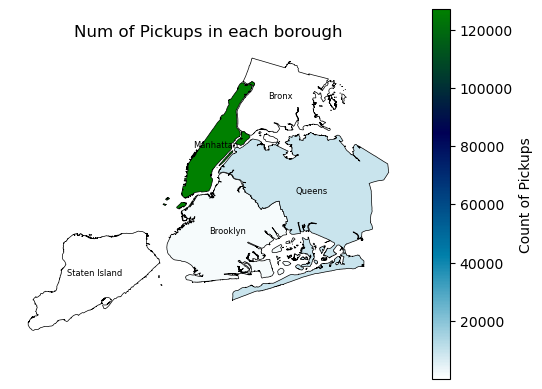

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

dobo_df = pu_borough

# Load the NYC shapefile using geopandas
nyc_shapefile = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile")

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='PUborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Pickups"})
ax.set_title("Num of Pickups in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['PUborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')

# Show the plot
plt.show()

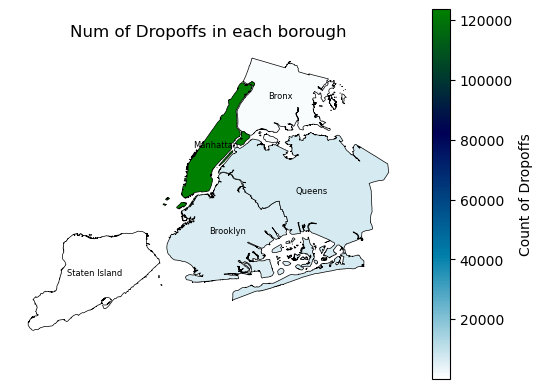

In [44]:
dobo_df = do_borough

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='DOborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Dropoffs"})
ax.set_title("Num of Dropoffs in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['DOborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')
    
# Show the plot
plt.show()

#### Zone with most pickups for short trips/ zone with most pickups for long trips

In [45]:
union_df.select('trip_distance').describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|            140205|
|   mean|3.0737578545700956|
| stddev| 16.62445272019441|
|    min|            -18.15|
|    max|           6016.06|
+-------+------------------+



According to the dustribution of trip distances (very right skewed) and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

Will need to adjust threshold when using FULL Dataset

In [46]:
short_trip = joined_df.filter(F.col('trip_distance')<30)

In [47]:
long_trip = joined_df.filter(F.col('trip_distance')>= 30)

In [48]:
from pyspark.sql.functions import desc
short_trip_PUzone = short_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [49]:
long_trip_PUzone = long_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [50]:
short_trip_DOzone = short_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [51]:
long_trip_DOzone = long_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [52]:
short_trip_PUzone.show()

+------------+--------------------+---------+-----+
|PULocationID|              PUzone|PUborough|count|
+------------+--------------------+---------+-----+
|         237|Upper East Side S...|Manhattan| 6303|
|         236|Upper East Side N...|Manhattan| 5841|
|         161|      Midtown Center|Manhattan| 5454|
|         186|Penn Station/Madi...|Manhattan| 4973|
|         162|        Midtown East|Manhattan| 4815|
|         170|         Murray Hill|Manhattan| 4309|
|         230|Times Sq/Theatre ...|Manhattan| 4296|
|         132|         JFK Airport|   Queens| 4258|
|         142| Lincoln Square East|Manhattan| 4235|
|          48|        Clinton East|Manhattan| 4212|
|         234|            Union Sq|Manhattan| 4035|
|         239|Upper West Side S...|Manhattan| 3769|
|         163|       Midtown North|Manhattan| 3658|
|         141|     Lenox Hill West|Manhattan| 3574|
|          79|        East Village|Manhattan| 3532|
|         107|            Gramercy|Manhattan| 3314|
|          6

In [53]:
long_trip_PUzone.show()

+------------+--------------------+-------------+-----+
|PULocationID|              PUzone|    PUborough|count|
+------------+--------------------+-------------+-----+
|         132|         JFK Airport|       Queens|   13|
|         135|   Kew Gardens Hills|       Queens|    3|
|         158|Meatpacking/West ...|    Manhattan|    3|
|         216|    South Ozone Park|       Queens|    2|
|         238|Upper West Side N...|    Manhattan|    2|
|         142| Lincoln Square East|    Manhattan|    2|
|         186|Penn Station/Madi...|    Manhattan|    1|
|         100|    Garment District|    Manhattan|    1|
|          14|           Bay Ridge|     Brooklyn|    1|
|         197|       Richmond Hill|       Queens|    1|
|         236|Upper East Side N...|    Manhattan|    1|
|         246|West Chelsea/Huds...|    Manhattan|    1|
|         262|      Yorkville East|    Manhattan|    1|
|          44|Charleston/Totten...|Staten Island|    1|
|         145|Long Island City/...|       Queens

Looks like most long trips are picked up from JFL Airports.

In [54]:
short_trip_DOzone.show()

+------------+--------------------+---------+-----+
|DOLocationID|              DOzone|DOborough|count|
+------------+--------------------+---------+-----+
|         236|Upper East Side N...|Manhattan| 5931|
|         237|Upper East Side S...|Manhattan| 5617|
|         161|      Midtown Center|Manhattan| 5065|
|         170|         Murray Hill|Manhattan| 4413|
|         162|        Midtown East|Manhattan| 3978|
|         230|Times Sq/Theatre ...|Manhattan| 3763|
|         142| Lincoln Square East|Manhattan| 3748|
|         141|     Lenox Hill West|Manhattan| 3706|
|         239|Upper West Side S...|Manhattan| 3700|
|          48|        Clinton East|Manhattan| 3688|
|         234|            Union Sq|Manhattan| 3429|
|         186|Penn Station/Madi...|Manhattan| 3420|
|         238|Upper West Side N...|Manhattan| 3228|
|          68|        East Chelsea|Manhattan| 3202|
|         163|       Midtown North|Manhattan| 3160|
|          79|        East Village|Manhattan| 2954|
|         10

In [55]:
long_trip_DOzone.show()

+------------+--------------------+-------------+-----+
|DOLocationID|              DOzone|    DOborough|count|
+------------+--------------------+-------------+-----+
|           1|      Newark Airport|          EWR|   11|
|         132|         JFK Airport|       Queens|    6|
|          44|Charleston/Totten...|Staten Island|    4|
|         141|     Lenox Hill West|    Manhattan|    2|
|         238|Upper West Side N...|    Manhattan|    1|
|         135|   Kew Gardens Hills|       Queens|    1|
|          13|   Battery Park City|    Manhattan|    1|
|         239|Upper West Side S...|    Manhattan|    1|
|         138|   LaGuardia Airport|       Queens|    1|
|          42|Central Harlem North|    Manhattan|    1|
|         200|Riverdale/North R...|        Bronx|    1|
|         158|Meatpacking/West ...|    Manhattan|    1|
|         171|  Murray Hill-Queens|       Queens|    1|
|         117|     Hammels/Arverne|       Queens|    1|
|         221|           Stapleton|Staten Island

Most dropoff for long trips are also airports (Newark and JFK).

#### Peak hours and Off-peak hours for taking taxi

In [56]:
union_df = union_df.withColumn('pu_hour',hour('parsed_pickup_datetime'))

In [57]:
union_df = union_df.withColumn('do_hour',hour('parsed_dropoff_datetime'))

In [58]:
pu_hour_df = union_df.groupby('pu_hour')\
            .agg(F.count('*').alias('PU_count')).orderBy('pu_hour')
do_hour_df = union_df.groupby('do_hour')\
            .agg(F.count('*').alias('DO_count')).orderBy('do_hour')

In [59]:
pu_df = pu_hour_df.toPandas()
do_df = do_hour_df.toPandas()

In [60]:
pu_df

,pu_hour,PU_count
0,0,3673
1,1,2496
2,2,1693
3,3,1238
4,4,947
5,5,1119
6,6,2720
7,7,4868
8,8,6425
9,9,6445


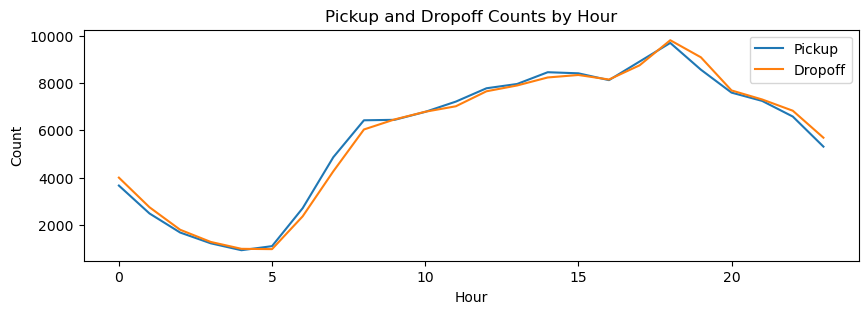

In [61]:
# Plot pickup and dropoff counts on the same plot
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(pu_df['pu_hour'], pu_df['PU_count'], label='Pickup')
ax.plot(do_df['do_hour'], do_df['DO_count'], label='Dropoff')

ax.set_title('Pickup and Dropoff Counts by Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

ax.legend()
plt.show()

Pickup and Dropoff has about the same counts by hour, with 4-5 am being the most off-peak hours and 4pm to 7pm being the peak-hours.

#### Visualize Pickup Counts by Month over 3 years (2019-2021)

In [62]:
# Extract the month and day of week from pickup time
union_df = union_df.withColumn("pickup_month", month("parsed_pickup_datetime"))
union_df = union_df.withColumn("pickup_dayofweek", dayofweek("parsed_pickup_datetime"))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

In [63]:
# Create a dummy variable of weekday
union_df = union_df.withColumn("pickup_weekday", when((union_df["pickup_dayofweek"] >= 2) & (union_df["pickup_dayofweek"] <= 6), 1).otherwise(0))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

In [64]:
# Create a season variable
union_df = union_df.withColumn(
    "season",
    when((union_df.pickup_month <= 2) | (union_df.pickup_month == 12), 1)
    .when((union_df.pickup_month >= 3) & (union_df.pickup_month <= 5), 2)
    .when((union_df.pickup_month >= 6) & (union_df.pickup_month <= 8), 3)
    .otherwise(4),
)

In [65]:
# Data Type Transformation
# Convert store_and_fwd_flag to a dummy variable
union_df = union_df.withColumn("store_and_fwd_flag", 
                               when(union_df.store_and_fwd_flag == "Y", 1).otherwise(0))


In [66]:
# Aggregate data by year and month
yearmonth_df = union_df.groupBy("Datayear", "pickup_month") \
                     .agg(sum("fare_amount").alias("fare"),
                          sum("total_amount").alias("total"),
                          sum("tip_amount").alias("tip"),
                          sum("trip_distance").alias("distance"),
                          count("*").alias("pickup_count"))

# Calculate averages
yearmonth_df = yearmonth_df.withColumn("avg_fare", F.col("fare") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_total", F.col("total") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_tip", F.col("tip") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_distance", F.col("distance") / F.col("pickup_count"))

In [67]:
yearmonth_plot = yearmonth_df.toPandas()

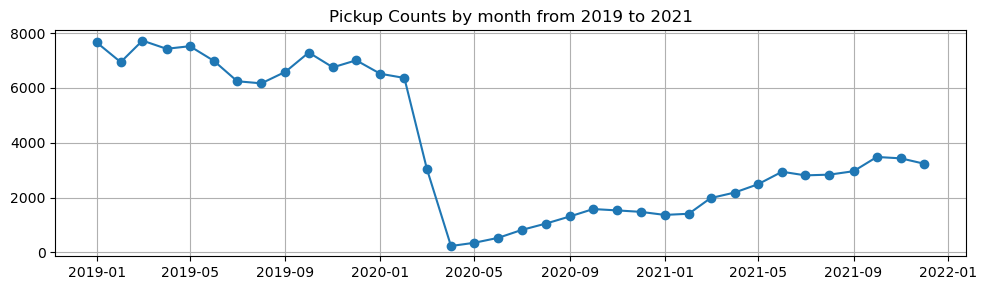

In [68]:
# Convert year and month to datetime and set as index
yearmonth_plot['date'] = pd.to_datetime(yearmonth_plot['Datayear'].astype(str) + '-' + yearmonth_plot['pickup_month'].astype(str) + '-01')
yearmonth_plot.set_index('date', inplace=True)

# Sort the DataFrame by date
yearmonth_plot = yearmonth_plot.sort_index()

# Filter data from 2019 to 2021
# yearmonth_plot = yearmonth_plot.loc['2019':'2021']

# Create a new figure
plt.figure(figsize=(10, 3))

# Plot pickup count
plt.plot(yearmonth_plot.index, yearmonth_plot["pickup_count"], marker='o')
plt.title('Pickup Counts by month from 2019 to 2021')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

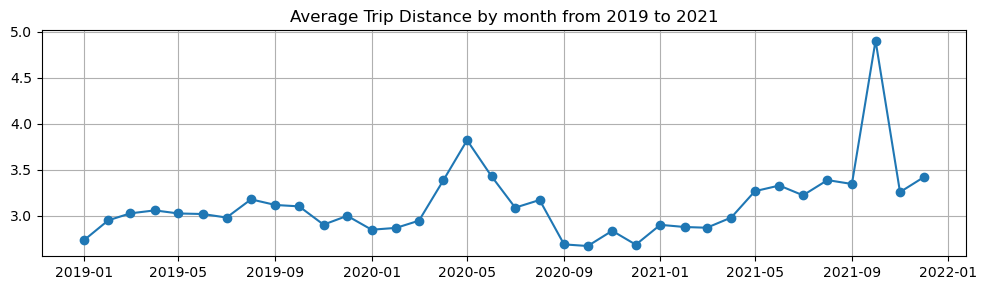

In [69]:
# Create a new figure
plt.figure(figsize=(10, 3))

# Plot average trip distance
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_distance"], marker='o')
plt.title('Average Trip Distance by month from 2019 to 2021')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Graph Computing - NYC Taxi Network

In [70]:
taxi_zone = taxi_zone.withColumn("id",taxi_zone["zone"])

joined_df = joined_df.withColumn("src", joined_df["PUzone"])
joined_df = joined_df.withColumn("dst", joined_df["DOzone"])

In [71]:
from graphframes import *

In [72]:
graph = GraphFrame(taxi_zone, joined_df)

In [73]:
graph.vertices.show(5)

+---------------+----------------+--------------------+----------+-------------+------------------+------------------+--------------------+
|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|                  id|
+---------------+----------------+--------------------+----------+-------------+------------------+------------------+--------------------+
| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 935996.8210162065|191376.74953083202|      Newark Airport|
|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1031085.7186032843|164018.75440320166|         Jamaica Bay|
|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|1026452.6168734727|254265.47865856893|Allerton/Pelham G...|
|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990633.9806410479| 202959.7823911368|       Alphabet City|
|0.0921464898574|4.9

In [74]:
graph.edges.count()

138279

In [75]:
degree = graph.degrees.orderBy('degree', ascending=False)
degree.show(10)

+--------------------+------+
|                  id|degree|
+--------------------+------+
|Upper East Side S...| 11806|
|Upper East Side N...| 11633|
|      Midtown Center| 10509|
|        Midtown East|  8872|
|         Murray Hill|  8730|
|Penn Station/Madi...|  8382|
|Times Sq/Theatre ...|  8142|
| Lincoln Square East|  8008|
|        Clinton East|  7835|
|Upper West Side S...|  7671|
+--------------------+------+
only showing top 10 rows



As expected, Upper East Side South and Upper East Side North are the top3 zones with the highest degree.

In [135]:
# compute the indegree of each vertex
indegree = graph.inDegrees.orderBy('inDegree', ascending=False)
indegree.show(10)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|Upper East Side N...|    5934|
|Upper East Side S...|    5546|
|      Midtown Center|    5071|
|         Murray Hill|    4367|
|        Midtown East|    3981|
| Lincoln Square East|    3785|
|Times Sq/Theatre ...|    3775|
|        Clinton East|    3744|
|Upper West Side S...|    3739|
|     Lenox Hill West|    3676|
+--------------------+--------+
only showing top 10 rows



In [139]:
# compute the outdegree of each vertex
outdegree = graph.outDegrees.orderBy('outDegree', ascending=False)
outdegree.show(10)

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|Upper East Side S...|     6378|
|Upper East Side N...|     5825|
|      Midtown Center|     5469|
|Penn Station/Madi...|     4983|
|        Midtown East|     4839|
|Times Sq/Theatre ...|     4345|
|         JFK Airport|     4292|
|         Murray Hill|     4273|
| Lincoln Square East|     4269|
|        Clinton East|     4161|
+--------------------+---------+
only showing top 10 rows



In [138]:
graph.inDegrees.orderBy('inDegree', ascending=True).show(10)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|   Rossville/Woodrow|       1|
|       Broad Channel|       1|
|     Freshkills Park|       1|
|         Great Kills|       1|
|New Dorp/Midland ...|       1|
|Heartland Village...|       1|
|         Westerleigh|       1|
|     Mariners Harbor|       2|
|       Arden Heights|       2|
| Grymes Hill/Clifton|       2|
+--------------------+--------+
only showing top 10 rows



In [141]:
graph.outDegrees.orderBy('outDegree', ascending=True).show(10)

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|          Bronx Park|        1|
|Marine Park/Floyd...|        1|
|         Westerleigh|        1|
|Saint George/New ...|        1|
|Bloomfield/Emerso...|        1|
|     Highbridge Park|        2|
|             Bayside|        2|
|         City Island|        2|
|      Middle Village|        2|
|          Whitestone|        2|
+--------------------+---------+
only showing top 10 rows



In [78]:
# rank by most popular routes
RouteCount = graph.edges.groupBy("src","dst").count().orderBy("count", ascending=False)
RouteCount.show(10)

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|Upper East Side S...|Upper East Side N...|  880|
|Upper East Side N...|Upper East Side S...|  825|
|Upper East Side N...|Upper East Side N...|  719|
|Upper East Side S...|Upper East Side S...|  690|
|Upper West Side S...|Upper West Side N...|  423|
|Upper East Side S...|      Midtown Center|  394|
|Upper West Side S...| Lincoln Square East|  384|
| Lincoln Square East|Upper West Side S...|  363|
|Upper East Side S...|        Midtown East|  345|
|Upper West Side N...|Upper West Side S...|  339|
+--------------------+--------------------+-----+
only showing top 10 rows



In [79]:
page_rank_df = graph.pageRank(resetProbability=0.15, tol=0.01).vertices.orderBy('pagerank',ascending=False)

23/05/15 18:05:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [80]:
page_rank_df.select('id','pagerank').show(10)

+--------------------+------------------+
|                  id|          pagerank|
+--------------------+------------------+
|Upper East Side N...| 6.358915512002757|
|Upper East Side S...|  5.76745294052107|
|      Midtown Center| 5.263215690471153|
|         Murray Hill| 5.187561901243975|
|        Clinton East| 4.445612213262635|
|        Midtown East| 4.233370230095104|
|Upper West Side N...| 4.193587566652068|
| Lincoln Square East|  4.17910305189116|
|     Lenox Hill West| 4.091558877057447|
|Upper West Side S...|4.0821425534632505|
+--------------------+------------------+
only showing top 10 rows



In [81]:
# graph.edges.filter("PUzone='Newark Airport'").show()

In [82]:
# from pyspark.context import SparkContext
# from pyspark.sql import SparkSession
# from graphframes import *

# import pyspark.sql.functions as F 
# from pyspark.sql.functions import udf, explode, col,lit, split, regexp_replace, regexp_extract
# from pyspark.sql.types import StringType, ArrayType

# import networkx as nx
# import matplotlib.pyplot as plt
# from tqdm import tqdm

In [83]:
# def plotGraph(pdf):
#     G = nx.from_pandas_edgelist(pdf[:50], "src", "dst", edge_attr=True, create_using=nx.MultiDiGraph())
#     counts = [i['count'] / 100 for i in dict(G.edges).values()]

#     plt.figure(figsize=(10, 10))
#     pos = nx.spring_layout(G)
#     edge_colors = range(len(G.edges()))  # Example: Assigning a range of colors to edges

#     nx.draw(
#         G,
#         with_labels=True,
#         node_color='skyblue',
#         width=counts,
#         edge_cmap=plt.cm.Blues,
#         edge_color='red',
#         font_size=9,
#         #edge_colors = (0.24, 0.24, 0.0), # Set the edge color
#         pos=pos
#     )
#     plt.show()

In [84]:
# # create a directed-graph from a dataframe
# def plotGraph(pdf):
#     G=nx.from_pandas_edgelist(pdf[:50], "src", "dst", 
#                               edge_attr=True, create_using=nx.MultiDiGraph())
#     counts = [i['count']/100 for i in dict(G.edges).values()]

#     plt.figure(figsize=(8,8))
#     pos = nx.spring_layout(G)
#     nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
#     plt.show()

In [85]:
# # top 10 most frequent taxi routes in NYC
# plt.figure(figsize=(10, 6))
# plotGraph(RouteCount.toPandas()[:10])

#### Clustering

In [104]:
from pyspark.sql.functions import col

# Create a GraphFrame object with the graph data
vertices_df = graph.vertices

# Create a dataframe with the inDegree, outDegree of each vertex
in_degrees_df = indegree.withColumnRenamed("id", "inDegreeId").withColumnRenamed("inDegree", "inDegreeVal")
out_degrees_df = outdegree.withColumnRenamed("id", "outDegreeId").withColumnRenamed("outDegree", "outDegreeVal")

# Join the dataframes to create a new dataframe with the inDegree, outDegree, and pageRank of each vertex
vertex_props_df = vertices_df \
    .join(in_degrees_df, vertices_df.id == in_degrees_df.inDegreeId, "left_outer") \
    .join(out_degrees_df, vertices_df.id == out_degrees_df.outDegreeId, "left_outer") \
    .join(page_rank_df, vertices_df.id == page_rank_df.id, "left_outer") \
    .select(vertices_df.id, col("inDegreeVal"), col("outDegreeVal"), col("pagerank"))

In [108]:
vertex_props_df = vertex_props_df.fillna(0)

In [111]:
# Cluster the vertices based on the inDegree, outDegree, and pagerank using KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["inDegreeVal", "outDegreeVal","pagerank"], outputCol="features")
data = assembler.transform(vertex_props_df).select("id", "features")

In [125]:
#Create and fit the Bisecting K-means model:
num_clusters = 3  # Set the desired number of clusters
bisecting_kmeans = BisectingKMeans(k=num_clusters, seed=42)
model = bisecting_kmeans.fit(data)

In [126]:
# Obtain the cluster assignments for each vertex
predictions = model.transform(data)

In [127]:
# Evaluate the clustering
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette score:", silhouette)

Silhouette score: 0.8743992644895279


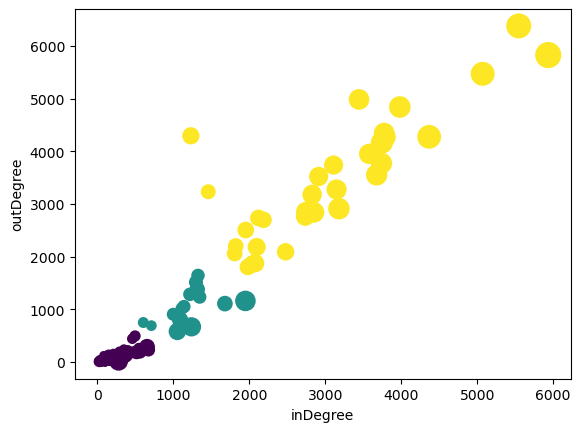

In [129]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pdf = predictions.select("id", "prediction").toPandas()

# Merge the Pandas DataFrame with the vertex properties DataFrame
merged_df = pd.merge(vertex_props_df.toPandas(), pdf, on="id")

# Scatter plot the clusters
plt.scatter(merged_df["inDegreeVal"], merged_df["outDegreeVal"], c=merged_df["prediction"], s=merged_df["pagerank"] * 50)
plt.xlabel("inDegree")
plt.ylabel("outDegree")
plt.show()